# Índice

- [1. Teoría](#1-teoría)
  - [1.1 Definición del jugador](#11-definición-del-jugador)
  - [1.2 Evaluación del entorno](#12-evaluación-del-entorno)
  - [1.3 Adaptación de la persistencia](#13-adaptación-de-la-persistencia)
  - [1.4 Condición de cambio de estrategia](#14-condición-de-cambio-de-estrategia)
  - [1.5 Dinámica de imitación](#15-dinámica-de-imitación)
  - [1.6 Resumen de variables](#16-resumen-de-variables)

# 1. Teoría

## 1.1 Definición del jugador

Cada jugador $i$ está caracterizado por las siguientes variables:

- $s_i(t) \in \{0, 1\}$: estrategia en el instante $t$  
  - $s_i(t) = 1$: el jugador coopera  
  - $s_i(t) = 0$: el jugador defecta

- $\tau_i(t) \in [\tau_D, \tau_U]$: nivel de persistencia. Representa el número de pasos mínimos que el jugador desea mantener su estrategia antes de considerar un cambio.

- $\Theta_i(t) \in \mathbb{N}_0$: temporizador que cuenta cuántos pasos consecutivos ha mantenido su estrategia actual sin cambiarla.

## 1.2 Evaluación del entorno

### a) Entorno local

$$
\varphi_i(t) = \frac{1}{k_i} \sum_{j \in \mathcal{N}_i} s_j(t)
$$

- $\mathcal{N}_i$: conjunto de vecinos de $i$  
- $k_i = |\mathcal{N}_i|$: número de vecinos  
- $s_j(t)$: estrategia del vecino $j$

### b) Entorno global

$$
\phi(t) = \frac{1}{N} \sum_{j=1}^{N} s_j(t)
$$

### c) Diferencia entre entornos

$$
\Delta E_i(t) = \varphi_i(t) - \phi(t)
$$

- Si $\Delta E_i(t) > 0$: el entorno local de $i$ es mejor que el global  
- Si $\Delta E_i(t) < 0$: el entorno local es peor

## 1.3 Adaptación de la persistencia

Si $\Delta E_i(t) > 0$, se incrementa $\tau_i(t)$ con probabilidad:

$$
P_{\text{aumento}} = \frac{1}{1 + \exp\left(-\frac{\Delta E_i(t)}{K_1}\right)}
$$

Si $\Delta E_i(t) < 0$, se reduce con probabilidad complementaria:

$$
P_{\text{disminución}} = 1 - P_{\text{aumento}}
$$

Actualización de $\tau_i(t)$:

- Si se aumenta:

$$
\tau_i(t) \leftarrow \min\left(\tau_i(t) + \Delta \tau, \tau_U\right)
$$

- Si se disminuye:

$$
\tau_i(t) \leftarrow \max\left(\tau_i(t) - \Delta \tau, \tau_D\right)
$$

## 1.4 Condición de cambio de estrategia

El jugador solo puede considerar cambiar de estrategia si:

$$
\Theta_i(t) \geq \tau_i(t)
$$

- Si no se cumple:

$$
\Theta_i(t+1) = \Theta_i(t) + 1
$$

- Si se cumple: el jugador pasa a evaluar la estrategia de un vecino

## 1.5 Dinámica de imitación

1. Se selecciona un vecino aleatorio $j \in \mathcal{N}_i$

2. Se calcula el payoff acumulado de $i$ y $j$:

$$
\pi_i(t) = \sum_{k \in \mathcal{N}_i} u(s_i(t), s_k(t)), \quad
\pi_j(t) = \sum_{k \in \mathcal{N}_j} u(s_j(t), s_k(t))
$$

Donde $u(s_a, s_b)$ es el resultado del juego del prisionero entre las estrategias $s_a$ y $s_b$.

**Nota**: $\pi_j(t)$ representa la suma de los pagos que obtiene el jugador $j$ al interactuar con sus propios vecinos en el mallado.

3. El jugador $i$ imita la estrategia de $j$ con probabilidad:

$$
P(s_i \leftarrow s_j) = \frac{1}{1 + \exp\left( -\frac{\pi_j(t) - \pi_i(t)}{K_2} \right)}
$$

## 1.6 Resumen de variables

| Símbolo | Significado |
|---------|-------------|
| $s_i(t)$ | Estrategia del jugador $i$ |
| $\tau_i(t)$ | Nivel de persistencia |
| $\Theta_i(t)$ | Temporizador |
| $\varphi_i(t)$ | Entorno local (promedio de cooperación entre vecinos) |
| $\phi(t)$ | Entorno global |
| $\Delta E_i(t)$ | Diferencia entre entorno local y global |
| $\pi_i(t), \pi_j(t)$ | Payoffs acumulados de $i$ y $j$ |
| $K_1$ | Ruido en persistencia |
| $K_2$ | Ruido en imitación |
| $\Delta \tau$ | Incremento/decremento permitido de $\tau_i$ |
| $\tau_D, \tau_U$ | Valores mínimo y máximo de persistencia |

# 2.Implementación Computacional

### SetUp

In [2]:
#Librerias
import numpy as np
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2.1 — Inicialización de la red y variables del modelo


Creamos una red cuadrada de tamaño $ L \times L = 100 \times 100 $ donde cada celda representa un jugador. Según el artículo, cada jugador comienza con los siguientes valores:

- **Estrategia inicial $ s_i(0) $**: asignada aleatoriamente, siendo 1 (cooperador) o 0 (defector), con una probabilidad del 50 % cada una.
- **Persistencia $tau_i(0)$**: todos los jugadores comienzan con nivel de persistencia 0.
- **Cronómetro $ell_i(0)$**: todos inician con su temporizador en 0, es decir, aún no han mantenido ninguna estrategia.

Estas condiciones coinciden exactamente con lo descrito en el artículo:

> “Initially, the two strategies of C and D are randomly distributed among the players with equal probability. For each player, \( \tau_i(0) \) and \( \ell_i \) are initialized to be 0.”


In [3]:
# Tamaño de la red 
L = 100                      
N = L * L                    
np.random.seed(0)            

# Matriz estrategia inicial (random)
s = np.random.choice([0, 1], size=(L, L))    # s_i(0)

# Matriz persistencia de cada jugador (todos a 0)
tau = np.zeros((L, L), dtype=int)           # τ_i(0)

# Matriz cronómetro de cada jugador (mantener estrategia)
ell = np.zeros((L, L), dtype=int)           # ℓ_i(0)

### 2.2 — Definición de vecinos con condiciones periódicas

El operador a % L devuelve el resto de dividir a entre L.  

- 5 % 3 = 2
- 9 % 4 = 1

**¿Para qué usamos `%` en la red?**

En una red \( L \times L \), cada jugador en la celda $i, j$ tiene 4 vecinos inmediatos:

- Arriba: $ (i-1, j) $
- Abajo: $(i+1, j) $
- Izquierda: $(i, j-1) $
- Derecha: $(i, j+1)$

Pero si el jugador está en un borde, alguno de esos índices puede quedar fuera.  
Usamos `% L` para aplicar **condiciones de frontera periódicas**: si sale por un borde, vuelve por el otro.

*Ejemplo:*

- Si $ i = 0 $, entonces $(i - 1) \% L = (-1) \% 100 = 99 $

Así, el jugador en la fila 0 tiene como vecino superior a la fila 99, cerrando la red como un toro.

In [4]:
def get_neighbors(i, j, L):
    # Devuelve las coordenadas de los 4 vecinos
    neighbors = [
        ((i + 1) % L, j),     # abajo
        ((i - 1) % L, j),     # arriba
        (i, (j + 1) % L),     # derecha
        (i, (j - 1) % L)      # izquierda
    ]
    return neighbors

### 2.3 — Cálculo del entorno Local $\varphi_i(t)$ y Global $\phi(t)$

**Entorno Local**

In [5]:
def phi_local(s, i, j, L):
    neighbors = get_neighbors(i, j, L)
    total = sum(s[x, y] for x, y in neighbors)
    return total / 4  # porcentaje vecinos colaboradores

**Entorno Global**

In [6]:
def phi_global(s):
    return np.mean(s)

### 2.4  Diferencia entre entornos  y adaptación de la persistencia $Tau_i(t)$

**Actualización de la tasa de persistencia $\tau_i(t)$**

La función `update_tau` implementa la adaptación dinámica de la persistencia de cada jugador según la diferencia entre su entorno local y el global:

1. **Cálculo de entornos:**
    - $\varphi_i(t)$: Fracción de cooperadores entre los vecinos inmediatos del jugador $(i, j)$.
    - $\phi(t)$: Fracción global de cooperadores en toda la red.

2. **Diferencia de entornos:**
    - $\Delta E_i(t) = \varphi_i(t) - \phi(t)$

3. **Probabilidad de ajuste (regla de Fermi):**
    - Se calcula la probabilidad $P$ de aumentar la persistencia:
      $$
      P = \frac{1}{1 + \exp\left(-\frac{\Delta E_i(t)}{K_1}\right)}
      $$
    - $K_1$ es un parámetro de "ruido" que regula la sensibilidad al entorno.

4. **Actualización de $\tau_i(t)$:**
    - Si $\Delta E_i(t) > 0$ y un número aleatorio $r < P$, se incrementa la persistencia:  
      $$
      \tau_i(t) \leftarrow \min(\tau_i(t) + \Delta\tau, \tau_U)
      $$
    - Si $\Delta E_i(t) < 0$ y $r < 1 - P$, se reduce la persistencia:  
      $$
      \tau_i(t) \leftarrow \max(\tau_i(t) - \Delta\tau, \tau_D)
      $$
    - Si $\Delta E_i(t) = 0$, la persistencia no cambia.


In [7]:
def update_tau(i, j, s, tau, L, tau_U, tau_D, delta_tau, K1):
    """
    i, j : Coordenadas del jugador en la red.
    
    s : Matriz de estrategias.
    
    tau :Matriz actual de persistencia τ_i(t) de cada jugador.

    tau_U :Valor máximo permitido para la persistencia.
    
    tau_D : Valor mínimo permitido para la persistencia.
    """

    # % cooperadores entono Local y Global
    phi_i = phi_local(s, i, j, L)
    phi_global_val = phi_global(s)

    # diferencia entre entornos
    delta_E = phi_i - phi_global_val

    # Probabilidad Fermi:aumentar persistencia
    P = 1 / (1 + np.exp(-delta_E / K1))
    
    r = np.random.rand()  # número aleatorio 

    # Ajuste
    if delta_E > 0 and r < P: # incrementamos en una unidad
        tau[i, j] = min(tau[i, j] + delta_tau, tau_U)
    elif delta_E < 0 and r < (1 - P):
        tau[i, j] = max(tau[i, j] - delta_tau, tau_D) # disminuimos
    # si ΔE = 0  no se cambia τ

    return tau[i, j]  # para ver el resultado si queremos

### 2.5 - Payoff y Estrategia

**Función Payoff**

In [8]:
def payoff(si, sj, b):
    if si == 1 and sj == 1:
        return 1      # R: cooperación mutua
    elif si == 1 and sj == 0:
        return 0      # S: el jugador coopera pero es traicionado
    elif si == 0 and sj == 1:
        return b      # T: el jugador traiciona a un cooperador
    else:
        return 0      # P: ambos traicionan

**Payoff Nodo**

In [9]:
def total_payoff(i, j, s, L, b):
    pi = 0
    si = s[i, j]
    neighbors = get_neighbors(i, j, L)

    for x, y in neighbors:
        sj = s[x, y]
        pi += payoff(si, sj, b)

    return pi #payoff total de los 4 vecinos jugador

**Función Estrategia**

La función `update_strategy` implementa la dinámica de cambio de estrategia para un jugador en la red, siguiendo el modelo descrito en la teoría. A continuación se detalla su funcionamiento:

1. **Restricción por persistencia**  
    Si el cronómetro $\ell_{i,j}$ es menor que la persistencia $\tau_{i,j}$, el jugador no puede cambiar de estrategia.  
    - Se incrementa $\ell_{i,j}$ en 1.
    - La función termina para este jugador.

2. **Evaluación de cambio de estrategia**  
    Si $\ell_{i,j} \geq \tau_{i,j}$:
    - Se selecciona un vecino aleatorio.
    - Se calculan los payoffs acumulados del jugador ($\pi_i$) y del vecino ($\pi_j$).
    - Se calcula la probabilidad de imitación usando la regla de Fermi:
      $$
      P = \frac{1}{1 + \exp\left(-\frac{\pi_j - \pi_i}{K_2}\right)}
      $$
    - Se genera un número aleatorio $r$ en $[0, 1]$.
      - Si $r < P$, el jugador imita la estrategia del vecino ($s_{i,j} = s_{x,y}$) y reinicia su cronómetro ($\ell_{i,j} = 0$).
      - Si no, simplemente incrementa su cronómetro ($\ell_{i,j} += 1$).



In [10]:
def update_strategy(i, j, s, ell, tau, L, b, K2):

    # cronometro < tau -> no se puede cambiar estrategia
    if ell[i, j] < tau[i, j]:
        ell[i, j] += 1
        return
    #  cronometro >= tau -> cambio estrategia
    neighbors = get_neighbors(i, j, L)
    x, y = neighbors[np.random.randint(len(neighbors))]

    si = s[i, j]
    sj = s[x, y]
    # calculo payoff vecinos
    pi = total_payoff(i, j, s, L, b)
    pj = total_payoff(x, y, s, L, b)

    P = 1 / (1 + np.exp(-(pj - pi) / K2))
    r = np.random.rand()
    # actualizar estrategia
    if r < P:
        s[i, j] = sj
        ell[i, j] = 0
    else:
        ell[i, j] += 1

# 3.Simulaciones

Esta función simula el modelo para un valor de $b$ dado, repitiendo la simulación 100 veces (réplicas) para obtener un promedio confiable de la fracción final de cooperadores.

- Inicializa la red y variables para cada réplica.
- En cada paso de tiempo, actualiza la persistencia y la estrategia de todos los jugadores.
- Durante los últimos `num_avg_steps`, guarda la fracción de cooperadores.
- Al final, promedia la fracción de cooperadores de todas las réplicas y la retorna.

Sirve para calcular cómo varía la cooperación según el parámetro $b$.

In [18]:
def simulate_replicas_for_b(b, L, num_steps, num_avg_steps, tau_U, tau_D, delta_tau, K1, K2):
    fC_b = []

    for _ in range(20):  
        s = np.random.choice([0, 1], size=(L, L))
        tau = np.zeros((L, L), dtype=int)
        ell = np.zeros((L, L), dtype=int)

        fC_trayectoria = []

        for step in range(num_steps):
            for i in range(L):
                for j in range(L):
                    update_tau(i, j, s, tau, L, tau_U, tau_D, delta_tau, K1)
            for i in range(L):
                for j in range(L):
                    update_strategy(i, j, s, ell, tau, L, b, K2)

            if step >= (num_steps - num_avg_steps):
                fC_trayectoria.append(np.mean(s))

        fC_b.append(np.mean(fC_trayectoria))

    return np.mean(fC_b)


## 3.1 Simulación Preliminar

Para imitar las curvas del artículo sin incurrir en tiempos de cómputo excesivos, hemos optado por una configuración preliminar con un número limitado de pasos y réplicas.

En cada combinación $(b, \tau_U)\$, se realizan:

$
20 \times 500 \times 10,\!000 = 100,\!000,\!000 \text{ operaciones}
$

Con 30 valores de \(b\), se obtiene:

$
30 \times 100,\!000,\!000 = 3,\!000,\!000,\!000 \text{ operaciones por curva}
$

Y al simular 6 curvas diferentes:

$
6 \times 3,\!000,\!000,\!000 = \boxed{18,\!000,\!000,\!000 \text{ operaciones en total}}
$

Esta configuración permite observar la forma general de las curvas $f_C(b)$ y su transición sin agotar los recursos computacionales.

In [32]:
L = 100
tau_D = 0
delta_tau = 1
K1 = 0.1
K2 = 0.1
num_steps = 500
num_avg_steps = 300
num_replicas = 20
b_values = np.linspace(1.0, 1.6, 30)

tau_U_values = [0, 1, 5, 10, 20, 100]
colors = ['red', 'green', 'blue', 'magenta', 'orange', 'purple']
markers = ['s', 's', 'o', 'o', '^', '^']

 Simulando todas las curvas τ_U:   0%|          | 0/6 [00:00<?, ?it/s]


 Simulando para τU = 0...








 Simulando todas las curvas τ_U:  17%|█▋        | 1/6 [3:03:19<15:16:35, 10999.11s/it]


 Simulando para τU = 1...






 Simulando todas las curvas τ_U:  33%|███▎      | 2/6 [5:49:40<11:33:22, 10400.64s/it]


 Simulando para τU = 5...






 Simulando todas las curvas τ_U:  50%|█████     | 3/6 [8:31:49<8:24:40, 10093.66s/it] 


 Simulando para τU = 10...






 Simulando todas las curvas τ_U:  67%|██████▋   | 4/6 [10:40:32<5:05:15, 9157.91s/it]


 Simulando para τU = 20...






 Simulando todas las curvas τ_U:  83%|████████▎ | 5/6 [12:53:49<2:25:39, 8739.39s/it]


 Simulando para τU = 100...






 Simulando todas las curvas τ_U: 100%|██████████| 6/6 [15:12:41<00:00, 9126.93s/it]  


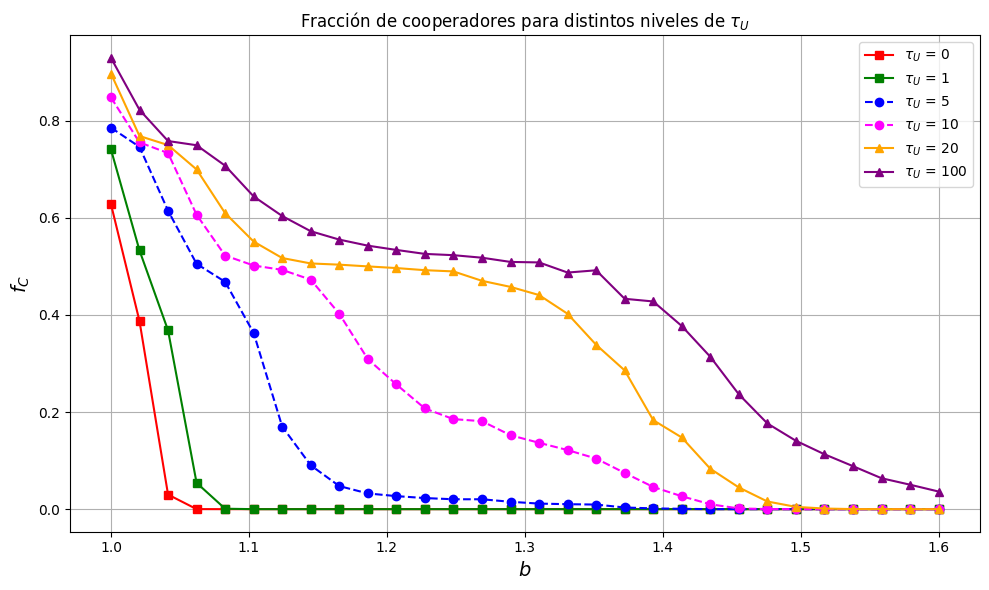

In [ ]:
for tau_U, color, marker in tqdm(zip(tau_U_values, colors, markers),
                                 total=len(tau_U_values),
                                 desc=" Simulando todas las curvas τ_U"):
    
    print(f"\n Simulando para τU = {tau_U}...")

    # Bucle interno sobre b con barra
    fC_values = Parallel(n_jobs=8)(
        delayed(simulate_replicas_for_b)(
            b, L, num_steps, num_avg_steps, tau_U, tau_D, delta_tau, K1, K2
        )
        for b in tqdm(b_values, desc=f"τU = {tau_U}", leave=False)
    )

    # Agregar la curva a la misma figura
    plt.plot(b_values, fC_values, label=rf"$\tau_U$ = {tau_U}",
             color=color, marker=marker, linestyle='--' if marker == 'o' else '-')
    
plt.figure(figsize=(10, 6))

# Configuración final de la gráfica
plt.xlabel(r'$b$', fontsize=14)
plt.ylabel(r'$f_C$', fontsize=14)
plt.title("Fracción de cooperadores para distintos niveles de $\\tau_U$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Interpretación Resultados**

El parámetro $ \tau_D $ representa el **nivel mínimo de persistencia** de un jugador, es decir, el **tiempo mínimo que debe mantener su estrategia antes de poder cambiarla**. Esta restricción implica que un jugador no puede modificar su comportamiento hasta que su contador interno $\ell$ iguale el valor de $ \tau $.

- Cuando $ \tau_D $ es **bajo**, los jugadores pueden adaptarse rápidamente a los cambios del entorno. Esto los hace más propensos a responder a incentivos individuales para traicionar (por ejemplo, un valor alto de $b$), lo que provoca que la cooperación desaparezca con facilidad.

- Por el contrario, cuando $ \tau_D $ es **alto**, los jugadores están obligados a mantener su estrategia durante más tiempo, incluso si el entorno se vuelve desfavorable. Esta **espera forzada** reduce la reacción impulsiva ante tentaciones individuales y favorece la persistencia de la cooperación, incluso en situaciones donde traicionar sería más rentable a corto plazo.

> En resumen, un mayor $ \tau_D $ implica que los individuos tardan más en poder cambiar de estrategia. Esta demora disminuye las decisiones impulsivas y permite que la cooperación se sostenga, incluso bajo presión de incentivos para traicionar.

**Resultados Gráficos**

Las curvas obtenidas logran capturar la **tendencia general** observada en el artículo original: a mayor $\tau_U$, mayor estabilidad de la cooperación y desplazamiento de la caída hacia valores mayores de $b$.

No obstante, se observa que las **transiciones no son tan abruptas** como en el paper. Esto se debe principalmente a las **limitaciones computacionales** impuestas en esta fase preliminar del experimento.

Para mejorar la precisión y lograr una mayor fidelidad con las curvas del artículo, se plantean las siguientes mejoras:

- **Aumentar el número de pasos de simulación**: el artículo utiliza 1000 pasos, mientras que nosotros usamos solo 500. Una mayor duración permite una transición más estable.
- **Incrementar el número de réplicas por punto**: más réplicas ayudan a suavizar el ruido y a capturar mejor los cambios bruscos.
- **Reconsiderar el muestreo de $b$** en curvas con mayor $\tau_U$: en lugar de un espaciado uniforme, se podrían concentrar más puntos alrededor del umbral donde ocurre la caída de $f_C$, tal como se intuye en el artículo original.

Estas modificaciones permitirían replicar con mayor precisión la forma característica de las curvas presentadas en el paper.

# 4.Propuesta Cadena Markov

A continuación, vamos a proponer una **cadena de Markov** para describir la evolución del nivel de persistencia $\tau_i(t)$ de cada jugador en el modelo. Al analizar el modelo original, nos damos cuenta de que la forma en que los jugadores mantienen o cambian su estrategia depende del entorno en cada momento. Esta observación sugiere que podríamos describir el nivel de persistencia utilizando una cadena de Markov, ya que este tipo de modelos se basa precisamente en que el valor que toma una variable en el futuro inmediato depende únicamente del estado actual, y no de lo ocurrido en el pasado.

## 4.1 Metodogía Matemática

## Definición Cadena



El nivel de persistencia de cada jugador representa el número mínimo de pasos durante los cuales dicho jugador mantiene su estrategia actual (colaborar o no colaborar). Su dinámica se expresa mediante la siguiente regla probabilística:

$$
\tau_i(t+1) =
\begin{cases}
\min(\tau_i(t) + \Delta\tau,\; \tau_U), & \text{con probabilidad } p^+ \\[6pt]
\max(\tau_i(t) - \Delta\tau,\; \tau_D), & \text{con probabilidad } p^-
\end{cases}
$$

donde las probabilidades $p^+$ y $p^-$ están dadas por:

$$
p^+ = \frac{1}{1 + \exp\left(-\frac{\Delta E_i(t)}{K_1}\right)}, \quad p^- = 1 - p^+
$$

La fórmula anterior muestra explícitamente que la actualización del nivel de persistencia depende únicamente de la variable $\Delta E_i(t)$, la cual se define como:

$$
\Delta E_i(t) = \varphi_i(t) - \phi(t)
$$

siendo:

- $\varphi_i(t)$ la proporción de colaboradores en el entorno local del jugador $i$.
- $\phi(t)$ la proporción global de colaboradores en toda la red en el instante $t$.



**Caracterización de la cadena de Markov**

En resumen, la probabilidad de que un jugador aumente o disminuya su nivel de persistencia $\tau_i(t)$ en cada paso depende del valor de $\Delta E_i(t)$, que a su vez varía en el tiempo en función del entorno del jugador y del estado global del sistema.

Esto significa que las **probabilidades de transición cambian en cada instante $t$**, lo cual implica que la matriz de transición también evoluciona con el tiempo. Por tanto, se trata de una **cadena de Markov no homogénea**.

El **espacio de estados** de esta cadena es **discreto y constante**, definido por todos los posibles niveles de persistencia que puede tomar un jugador entre un valor mínimo $\tau_D$ y un máximo $\tau_U$, en incrementos fijos de tamaño $\Delta\tau$:

$$
\mathcal{S} = \{\tau_D,\; \tau_D + \Delta\tau,\; \tau_D + 2\Delta\tau,\; \dots,\; \tau_U\}
$$



<div style="border-left: 4px solid #2ecc71; background-color: #eafaf1; padding: 10px; margin: 10px 0;">
  <strong> Tipo de cadena:</strong><br>
  Cadena de Markov <strong>no homogénea</strong> con <strong>espacio de estados discreto</strong>.
</div>

## Matriz Transición

Como se ha mencionado anteriormente, la cadena de Markov propuesta es **no homogénea**, ya que las probabilidades de transición varían en el tiempo según el entorno social del jugador.

La probabilidad de que un jugador **aumente su nivel de persistencia** en un paso de tiempo está dada por la siguiente expresión logística:

$$
p^+ = P(\tau_i \to \tau_i + \Delta\tau) = \frac{1}{1 + \exp\left(-\frac{\Delta E_i(t)}{K_1}\right)}
$$

La probabilidad de que **disminuya su persistencia** es simplemente la complementaria:

$$
p^- = P(\tau_i \to \tau_i - \Delta\tau) = 1 - p^+
$$



**Casos extremos**

- Si el jugador ya se encuentra en el **mínimo nivel de persistencia** $\tau_D$, **solo puede aumentarla**:
  $$
  P(\tau_i = \tau_D \to \tau_D - \Delta\tau) = 0
  $$

- Si el jugador está en el **máximo nivel permitido** $\tau_U$, **solo puede disminuirla**:
  $$
  P(\tau_i = \tau_U \to \tau_U + \Delta\tau) = 0
  $$



**Ejemplo de matriz de transición**

Supongamos un espacio de estados:

$$
\mathcal{S} = \{0,\; 1,\; 2,\; 3\}
$$

La matriz de transición $P(t)$ en este caso, en función de $p^+$ y $p^-$, tendría la siguiente forma:

$$
P(t) =
\begin{bmatrix}
0 & p^+ & 0 & 0 \\
p^- & 0 & p^+ & 0 \\
0 & p^- & 0 & p^+ \\
0 & 0 & p^- & 0
\end{bmatrix}
$$

- En la primera fila (estado 0): solo se puede subir a 1  
- En la última fila (estado 3): solo se puede bajar a 2  
- En los estados intermedios (1 y 2): se puede subir o bajar según $p^+$ y $p^-$

Esta matriz cambia en cada instante $t$, ya que $p^+$ depende de $\Delta E_i(t)$, y por tanto de la configuración dinámica de la red.

## Análisis de los estados y Distribución Estacionaria## 

**Irreducibilidad**  
La cadena es irreducible, ya que desde cualquier estado del espacio de persistencia $\mathcal{S}$ es posible alcanzar cualquier otro mediante una secuencia finita de transiciones. Esto se debe a que, excepto en los extremos, los jugadores pueden aumentar o disminuir su nivel de persistencia con probabilidad positiva. Por tanto, todos los estados están conectados.

**Aperiodicidad**  
La cadena es también aperiódica, ya que no sigue ciclos con periodicidad fija. Las transiciones dependen del entorno local y global del jugador, el cual varía constantemente. Esta variabilidad rompe cualquier patrón cíclico y permite que los saltos entre estados se produzcan de forma flexible en el tiempo.


<div style="text-align: center;">
  <img src="img/diagrama_cuadrado_tau.png" width="300"><br>
  <em>Diagrama de estados para la cadena de Markov con niveles de persistencia tau {0, 1, 2, 3\}.</em>
</div>

**Distribución estacionaria en el caso homogéneo**  
Si la cadena fuera homogénea, es decir, si la matriz de transición se mantuviera constante en el tiempo, podría definirse una distribución estacionaria $\pi$ que representaría cómo se estabiliza el sistema en el largo plazo. Esta distribución cumpliría la ecuación:

$$
\pi \cdot P = \pi, \quad \sum_{\tau \in \mathcal{S}} \pi(\tau) = 1
$$

**Aplicación en el caso no homogéneo**  
En el caso que nos ocupa, la cadena es no homogénea, ya que las probabilidades de transición cambian en cada instante debido a la evolución del entorno. En este contexto, no puede hablarse de una distribución estacionaria fija.

No obstante, una posibilidad sería estudiar la **distribución límite** del sistema. Esta distribución, si existe, describe la proporción de jugadores en cada nivel de persistencia cuando el tiempo tiende a infinito. Sin embargo, para que esta distribución límite esté bien definida, la cadena debe cumplir una serie de condiciones técnicas que no se garantizan en nuestro modelo.

Por ello, una forma práctica de abordar el análisis es observar cómo evoluciona la matriz de transición a lo largo del tiempo. Esta evolución refleja cómo cambia la dinámica del sistema y permite estudiar, de manera empírica, hacia dónde tiende el comportamiento colectivo de los jugadores.

Esta evolución puede interpretarse como una aproximación al comportamiento asintótico del sistema. Además, puede analizarse por separado para cooperadores y desertores, con el objetivo de identificar posibles diferencias estructurales entre ambos grupos en cuanto a sus niveles de persistencia y su papel en la formación de clusters cooperativos.

## Implemenracion Computacional

Con el objetivo de comparar el impacto de una cadena de Markov sobre la dinámica de persistencia, implementamos un modelo de referencia donde **la persistencia de todos los jugadores es constante y no evoluciona en el tiempo**.
En lugar de adaptar dinámicamente el valor de $\tau_i(t)$ según el entorno (como en el modelo del paper), aquí asignamos un valor fijo $\tau_{\text{const}}$ a todos los jugadores. Esto significa que **los jugadores solo pueden cambiar su estrategia si han mantenido su estrategia actual durante al menos $\tau_{\text{const}}$ pasos consecutivos**.

In [12]:
def update_strategy_base(i, j, s, ell, tau_const, L, b, K2):
    if ell[i, j] < tau_const: #tau_const es un VALOR FIJO para todos
        ell[i, j] += 1
        return

    neighbors = get_neighbors(i, j, L)
    x, y = neighbors[np.random.randint(len(neighbors))]

    si = s[i, j]
    sj = s[x, y]

    pi = total_payoff(i, j, s, L, b)
    pj = total_payoff(x, y, s, L, b)

    P = 1 / (1 + np.exp(-(pj - pi) / K2))
    if np.random.rand() < P:
        s[i, j] = sj
        ell[i, j] = 0
    else:
        ell[i, j] += 1

In [19]:
def simulate_replicas_base(b, L, num_steps, num_avg_steps, tau_const, K2):
    fC_b = []

    for _ in range(20):  # número de réplicas
        s = np.random.choice([0, 1], size=(L, L))
        ell = np.zeros((L, L), dtype=int)

        fC_trayectoria = []

        for step in range(num_steps):
            for i in range(L):
                for j in range(L):
                    update_strategy_base(i, j, s, ell, tau_const, L, b, K2) #funcion estegaia para el base

            if step >= (num_steps - num_avg_steps):
                fC_trayectoria.append(np.mean(s))

        fC_b.append(np.mean(fC_trayectoria))

    return np.mean(fC_b)

### Comparación de la cooperación media final $ f_C $ en función del parámetro $b$

Este gráfico representa cómo evoluciona la fracción de jugadores que cooperan $f_C(t)$ en el tiempo (número de pasos de Monte Carlo) para ambos modelos:

- **Modelo base**: la persistencia de los jugadores es constante (no hay cadena de Markov).
- **Modelo Markoviano**: la persistencia se adapta dinámicamente con una cadena de Markov.

In [15]:
import os



In [16]:
output_dir = "apartado_2_copy"
os.makedirs(output_dir, exist_ok=True)

In [20]:
L = 50  # Red más pequeña para mayor velocidad
num_steps = 300  # Menos pasos de Monte Carlo
num_avg_steps = 100  # Pasos usados para promediar f_C
tau_const = 5
tau_U = 20
tau_D = 0
delta_tau = 1
K1 = 0.1
K2 = 0.1
b_values = np.linspace(1.0, 1.5, 10)

# Carpeta donde se guardarán los resultados
output_dir = "output_apartado2"
os.makedirs(output_dir, exist_ok=True)

# Inicializar listas para almacenar resultados
fC_base_list = []
fC_markov_list = []

# Ejecutar simulaciones
for idx, b in enumerate(b_values):
    print(f"Simulando para b = {b:.2f} ...")

    # Modelo base: persistencia constante
    fc_base = simulate_replicas_base(b, L, num_steps, num_avg_steps, tau_const, K2)

    # Modelo Markoviano: persistencia dinámica adaptativa
    fc_markov = simulate_replicas_for_b(b, L, num_steps, num_avg_steps, tau_U, tau_D, delta_tau, K1, K2)

    # Guardar resultados intermedios
    fC_base_list.append(fc_base)
    fC_markov_list.append(fc_markov)

    # Guardado tras cada iteración
    np.save(os.path.join(output_dir, "b_values.npy"), b_values[:idx+1])
    np.save(os.path.join(output_dir, "fC_base.npy"), fC_base_list)
    np.save(os.path.join(output_dir, "fC_markov.npy"), fC_markov_list)

Simulando para b = 1.00 ...
Simulando para b = 1.06 ...
Simulando para b = 1.11 ...
Simulando para b = 1.17 ...
Simulando para b = 1.22 ...
Simulando para b = 1.28 ...
Simulando para b = 1.33 ...
Simulando para b = 1.39 ...
Simulando para b = 1.44 ...
Simulando para b = 1.50 ...


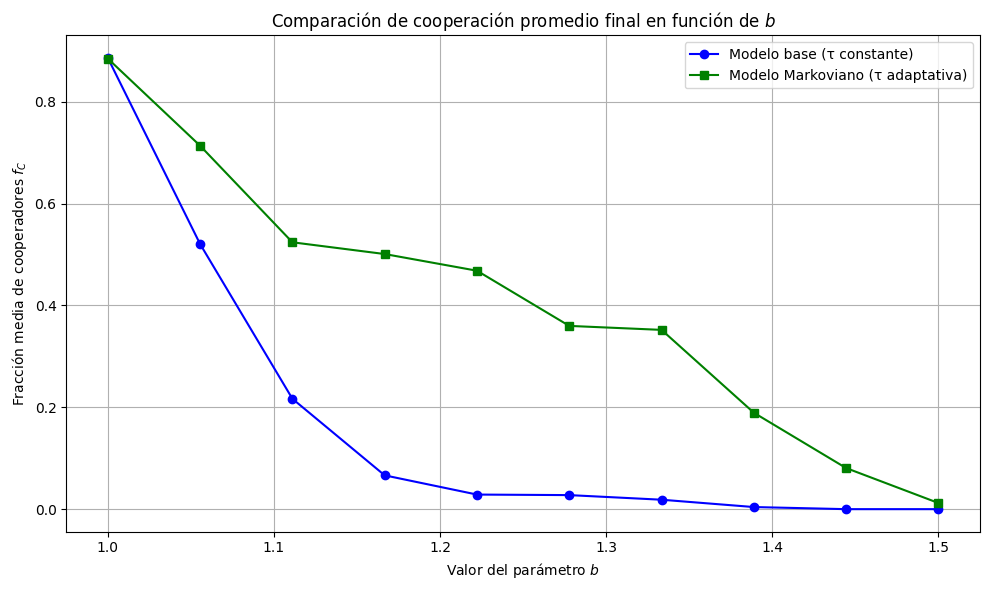

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(b_values, fC_base_list, marker='o', label='Modelo base (τ constante)', color='blue')
plt.plot(b_values, fC_markov_list, marker='s', label='Modelo Markoviano (τ adaptativa)', color='green')
plt.xlabel('Valor del parámetro $b$')
plt.ylabel('Fracción media de cooperadores $f_C$')
plt.title('Comparación de cooperación promedio final en función de $b$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribución de $tau_i$ final para cooperadores y desertores

Este gráfico muestra cómo se distribuyen los valores del nivel de persistencia  $\tau_i $ entre los jugadores al finalizar una simulación con $b = 1.1$, bajo la dinámica Markoviana.

Se diferencian dos curvas:

- En **azul**, la distribución de  $au_i$ entre los jugadores que cooperan $s_i = 1$.
- En **rojo**, la distribución de $tau_i $ entre los desertores $ s_i = 0 $.


In [ ]:
s = np.random.choice([0, 1], size=(L, L))
tau = np.zeros((L, L), dtype=int)
ell = np.zeros((L, L), dtype=int)

# Simulación del modelo Markoviano
for step in range(num_steps):
    for i in range(L):
        for j in range(L):
            update_tau(i, j, s, tau, L, tau_U, tau_D, delta_tau, K1)
    for i in range(L):
        for j in range(L):
            update_strategy(i, j, s, ell, tau, L, b, K2)

# Separar τ según estrategia
tau_coop = []
tau_def = []

for i in range(L):
    for j in range(L):
        if s[i, j] == 1:
            tau_coop.append(tau[i, j])
        else:
            tau_def.append(tau[i, j])

# Crear histograma
plt.figure(figsize=(10, 6))
bins = np.arange(tau_D, tau_U + 2) - 0.5  # bordes centrados

plt.hist(tau_coop, bins=bins, alpha=0.6, color='blue', label='Cooperadores', density=True)
plt.hist(tau_def, bins=bins, alpha=0.6, color='red', label='Desertores', density=True)

plt.xlabel('Nivel de persistencia $\\tau_i$')
plt.ylabel('Frecuencia relativa')
plt.title('Distribución final de $\\tau_i$ para cooperadores y desertores (b = 1.1)')
plt.legend()
plt.grid(True)
plt.tight_layout()


### Estabilidad de la cooperación frente a variaciones en $K_1$



In [22]:
import os
import numpy as np

# Parámetros del modelo
L = 50
num_steps = 300
num_avg_steps = 100
tau_const = 5
tau_U = 20
tau_D = 0
delta_tau = 1
K2 = 0.1
b = 1.1  # valor fijo para este experimento

K1_values = [0.1, 1, 10]

# Crear carpeta exclusiva para este experimento
output_dir = "robustez_K1"
os.makedirs(output_dir, exist_ok=True)

# Inicializar lista para almacenar los resultados
fC_k1_list = []

# Simular para cada valor de K1
for idx, K1 in enumerate(K1_values):
    print(f"Simulando para K1 = {K1} ...")
    
    # Ejecutar simulación con modelo Markoviano
    fc_markov = simulate_replicas_for_b(b, L, num_steps, num_avg_steps, tau_U, tau_D, delta_tau, K1, K2)
    
    # Guardar resultados
    fC_k1_list.append(fc_markov)
    
    # Guardar resultados tras cada iteración
    np.save(os.path.join(output_dir, "K1_values.npy"), K1_values[:idx+1])
    np.save(os.path.join(output_dir, "fC_markov_K1.npy"), fC_k1_list)

Simulando para K1 = 0.1 ...
Simulando para K1 = 1 ...
Simulando para K1 = 10 ...


FileNotFoundError: [Errno 2] No such file or directory: 'K1_values.npy'